![](https://www.moati.com.au/wp-content/uploads/2022/05/knee-arthritis-surgery.jpg)

# Initial Imports

In [ ]:
pip install opencv-python

In [ ]:
import tensorflow
import numpy as np
import keras
import cv2,os
import matplotlib 
import sklearn


# Data Preprocessing

In [1]:
import os
import numpy as np
import cv2
from keras.utils import to_categorical

# Define path and parameters
data_path = '/Users/apple/Desktop/PG/Summer-24/image-DL/knee-arthritis-detection-algo/Training'
img_size = 299 #299 for Xception model #256 for CNN

# Load categories excluding .DS_Store
categories = [category for category in os.listdir(data_path) if not category.endswith('.DS_Store')]

# Create label dictionary
label_dict = {category: i for i, category in enumerate(categories)}

# Initialize data and label lists
data = []
label = []

# Process images and labels
for category in categories:
    folder_path = os.path.join(data_path, category)
    img_names = os.listdir(folder_path)
    
    for img_name in img_names:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        try:
            rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            resized = cv2.resize(rgb, (img_size, img_size))
            data.append(resized)
            label.append(label_dict[category])
        except Exception as e:
            print('Exception:', e)

/Users/apple/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Rescale and assign  catagorical labels

In [2]:
# data=np.array(data)/255.0
# data=np.reshape(data,(data.shape[0],img_size,img_size,1))
data = np.array(data) / 255.0
data = np.reshape(data, (data.shape[0], img_size, img_size, 3))
label=np.array(label)

from keras.utils import to_categorical
# new_label= to_categorical(label)
new_label = to_categorical(label, num_classes=len(categories))


In [3]:
new_label.shape

(1650, 5)

In [4]:
data.shape

(1650, 299, 299, 3)

In [5]:
data.shape[1:]

(299, 299, 3)

# Model Creation

In [18]:
from keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Dropout  # Import both layers
from keras.models import Model

In [19]:
# Define the number of classes in your dataset (replace 5 with your actual number)
num_classes = 5

# Load the Xception model, excluding the top layers (include_top=False)
# We'll add our own classification layers later
xception_base = Xception(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the pre-trained layers to prevent them from being updated during training
for layer in xception_base.layers:
    layer.trainable = False


In [20]:
# Add a GlobalAveragePooling2D layer to average the output of the Xception model
x = GlobalAveragePooling2D()(xception_base.output)

# Add your own dense layers for classification
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model by combining the pre-trained base and your classification layers
model = Model(inputs=xception_base.input, outputs=predictions)


In [21]:
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
from keras.optimizers import Adam

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


# Model Summary 

In [22]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 149, 149,  │        864 │ input_layer_1[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 149, 149,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 149, 149,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 147, 147,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 147, 147,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 147, 147,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 147, 147,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 147, 147,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 147, 147,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 147, 147,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 147, 147,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 74, 74,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 74, 74,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 74, 74,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 74, 74,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 74, 74,    │          0 │ add_12[0][0]    

 Total params: 22,964,781 (87.60 MB)

 Trainable params: 2,103,301 (8.02 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

# Splitting data into traning and testing

In [23]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, new_label, test_size=0.1)

# Print the updated values to confirm
print("Categories:", categories)
print("Label Dictionary:", label_dict)
print("Shape of new_label:", new_label.shape)
print("Unique values in new_label:", np.unique(np.argmax(new_label, axis=1)))

Categories: ['1Doubtful', '4Severe', '2Mild', '0Normal', '3Moderate']
Label Dictionary: {'1Doubtful': 0, '4Severe': 1, '2Mild': 2, '0Normal': 3, '3Moderate': 4}
Shape of new_label: (1650, 5)
Unique values in new_label: [0 1 2 3 4]


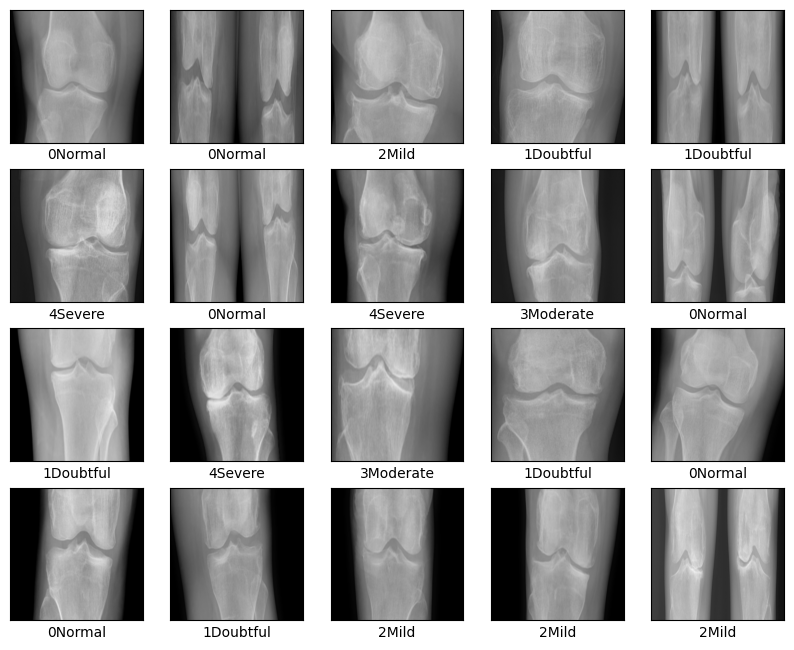

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(x_test[i]))
    plt.xlabel(categories[np.argmax(y_test[i])])
plt.show()

In [25]:
# Augmenting dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator with augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the ImageDataGenerator on the training data
datagen.fit(x_train)


# Model Training

In [26]:
print("Number of unique classes:", len(np.unique(label)))

Number of unique classes: 5


In [27]:
print("Categories:", categories)
print("Label Dictionary:", label_dict)
print("Shape of new_label:", new_label.shape)
print("Unique values in new_label:", np.unique(np.argmax(new_label, axis=1)))

Categories: ['1Doubtful', '4Severe', '2Mild', '0Normal', '3Moderate']
Label Dictionary: {'1Doubtful': 0, '4Severe': 1, '2Mild': 2, '0Normal': 3, '3Moderate': 4}
Shape of new_label: (1650, 5)
Unique values in new_label: [0 1 2 3 4]


In [28]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [29]:
# history=model.fit(x_train,y_train,epochs=100,validation_split=0.2)
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=100,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/100


/Users/apple/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 46s 864ms/step - accuracy: 0.3146 - loss: 1.5543 - val_accuracy: 0.3879 - val_loss: 1.4695
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 36s 738ms/step - accuracy: 0.3437 - loss: 1.4904 - val_accuracy: 0.4424 - val_loss: 1.4388
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 35s 719ms/step - accuracy: 0.3516 - loss: 1.4635 - val_accuracy: 0.4485 - val_loss: 1.4107
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 35s 719ms/step - accuracy: 0.3624 - loss: 1.4537 - val_accuracy: 0.4667 - val_loss: 1.3811
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 36s 722ms/step - accuracy: 0.3664 - loss: 1.4333 - val_accuracy: 0.4727 - val_loss: 1.3584
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 36s 724ms/step - accuracy: 0.4064 - loss: 1.3772 - val_accuracy: 0.4848 - val_loss: 1.3366
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 36s 722ms/step - accuracy: 0.4181 - loss: 1.3537 - val_accuracy: 0.4848 - val_loss: 1.3094
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 36s 724ms/step - accuracy: 0.4457 - loss: 1.3234 - val_accuracy

# Export The Model

In [30]:
model.save('model.h5')

# Plot The Training Loss And Accuracy

In [31]:
from matplotlib import pyplot as plt

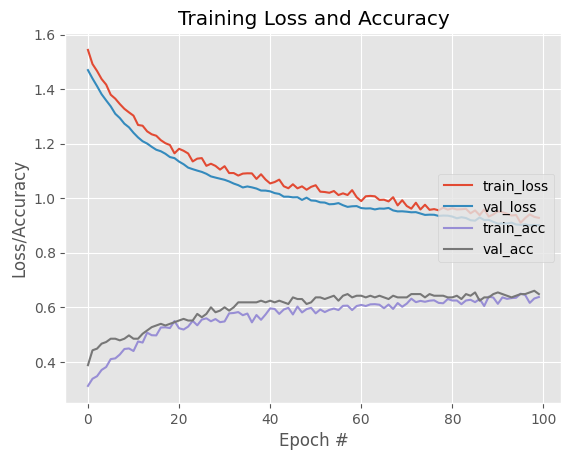

In [32]:
from matplotlib import pyplot as plt
N = 100 #number of epochs

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("CNN_Model")

# Accuracy

In [33]:
vaL_loss, val_accuracy= model.evaluate(x_test, y_test, verbose=0)
print("test loss:", vaL_loss,'%')
print("test accuracy:", val_accuracy,"%")

test loss: 0.9001174569129944 %
test accuracy: 0.6545454263687134 %


# Trying to fix overfitting

In [ ]:
# Augmenting dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator with augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the ImageDataGenerator on the training data
datagen.fit(x_train)


In [ ]:
# Adding Dropout layers and Regularizing model
from keras.applications import Xception
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.regularizers import l2

# Define the number of classes in your dataset
num_classes = len(categories)

# Load the Xception model, excluding the top layers
xception_base = Xception(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the pre-trained layers
for layer in xception_base.layers:
    layer.trainable = False

# Add a GlobalAveragePooling2D layer
x = GlobalAveragePooling2D()(xception_base.output)

# Add your own dense layers with dropout and L2 regularization
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=xception_base.input, outputs=predictions)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary
model.summary()


In [ ]:
# Training this model with augmented data and early stopping for tackling overfitting
from keras.callbacks import EarlyStopping

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model using the data generator
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=100,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping]
)


# Prediction

In [ ]:
X = 32

img_size = 256

img_single = x_test[X]
img_single = cv2.resize(img_single, (img_size, img_size))
img_single = (np.expand_dims(img_single, 0))
img_single = img_single.reshape(img_single.shape[0],256,256,1)

predictions_single = model.predict(img_single)
print('A.I predicts:',categories[np.argmax(predictions_single)])
print("Correct prediction for label",np.argmax(y_test[X]),'is',categories[np.argmax(y_test[X])])
plt.imshow(np.squeeze(img_single))
plt.grid(False)
plt.show()

# Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

test_labels = np.argmax(y_test, axis=1)
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=-1)


cm  = confusion_matrix(test_labels, predictions)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(5), ['Normal','Doubtful','Mid','Moderate','Severe'], fontsize=16)
plt.yticks(range(5), ['Normal','Doubtful','Mid','Moderate','Severe'], fontsize=16)
plt.show()